In [22]:
!git clone https://github.com/afozbek/Track_Data

fatal: destination path 'Track_Data' already exists and is not an empty directory.


In [23]:
!ls Track_Data

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [25]:
datadir = 'Track_Data'
columns = ['center', 'left', 'right',
           'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'),
             names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\center_2019_01_29_18_32_35_352.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\left_2019_01_29_18_32_35_352.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\right_2019_01_29_18_32_35_352.jpg,0.0,0.0,0.0,0.000084
1,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\center_2019_01_29_18_32_35_454.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\left_2019_01_29_18_32_35_454.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\right_2019_01_29_18_32_35_454.jpg,0.0,0.0,0.0,0.000080
2,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\center_2019_01_29_18_32_35_560.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\left_2019_01_29_18_32_35_560.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\right_2019_01_29_18_32_35_560.jpg,0.0,0.0,0.0,0.000079
3,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\center_2019_01_29_18_32_35_664.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\left_2019_01_29_18_32_35_664.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\right_2019_01_29_18_32_35_664.jpg,0.0,0.0,0.0,0.000078
4,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\center_2019_01_29_18_32_35_785.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\left_2019_01_29_18_32_35_785.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\right_2019_01_29_18_32_35_785.jpg,0.0,0.0,0.0,0.000080


In [26]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_01_29_18_32_35_352.jpg,left_2019_01_29_18_32_35_352.jpg,right_2019_01_29_18_32_35_352.jpg,0.0,0.0,0.0,0.000084
1,center_2019_01_29_18_32_35_454.jpg,left_2019_01_29_18_32_35_454.jpg,right_2019_01_29_18_32_35_454.jpg,0.0,0.0,0.0,0.000080
2,center_2019_01_29_18_32_35_560.jpg,left_2019_01_29_18_32_35_560.jpg,right_2019_01_29_18_32_35_560.jpg,0.0,0.0,0.0,0.000079
3,center_2019_01_29_18_32_35_664.jpg,left_2019_01_29_18_32_35_664.jpg,right_2019_01_29_18_32_35_664.jpg,0.0,0.0,0.0,0.000078
4,center_2019_01_29_18_32_35_785.jpg,left_2019_01_29_18_32_35_785.jpg,right_2019_01_29_18_32_35_785.jpg,0.0,0.0,0.0,0.000080


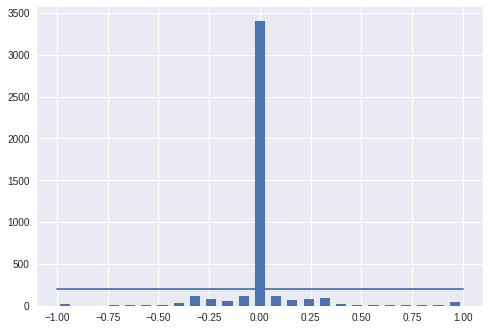

In [27]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),
        (samples_per_bin, samples_per_bin))

total data: 4345
removed 3202
remaining 1143


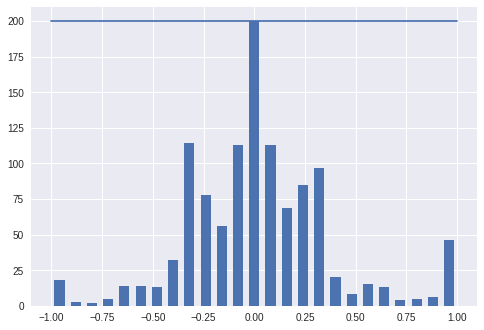

In [28]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),
        (samples_per_bin, samples_per_bin))

In [29]:
print(data.iloc[1]) #iloc-->records based on the indexes
def load_img_steering(datadir, data):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  #Convert the input to an array.  
  image_paths = np.asarray(image_path) 
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_01_29_18_32_36_607.jpg
left        left_2019_01_29_18_32_36_607.jpg  
right       right_2019_01_29_18_32_36_607.jpg 
steering   -0.284413                          
throttle    0.284413                          
reverse     0                                 
speed       0.267132                          
Name: 12, dtype: object


In [0]:
#Split arrays or matrices into random train and test subsets
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

In [31]:
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 914
Valid Samples: 229


Text(0.5, 1.0, 'Valid set')

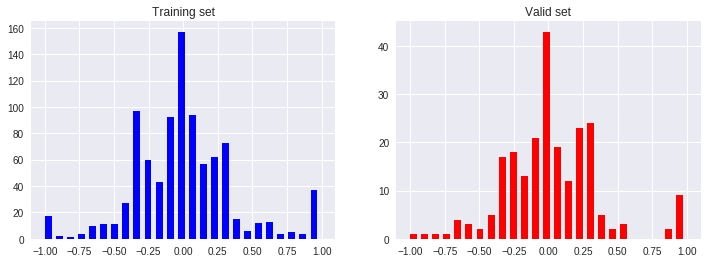

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Valid set')

In [0]:
def img_preprocess(img_path):
  img = mpimg.imread(img_path)
  img = img[60:136, :,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img / 255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

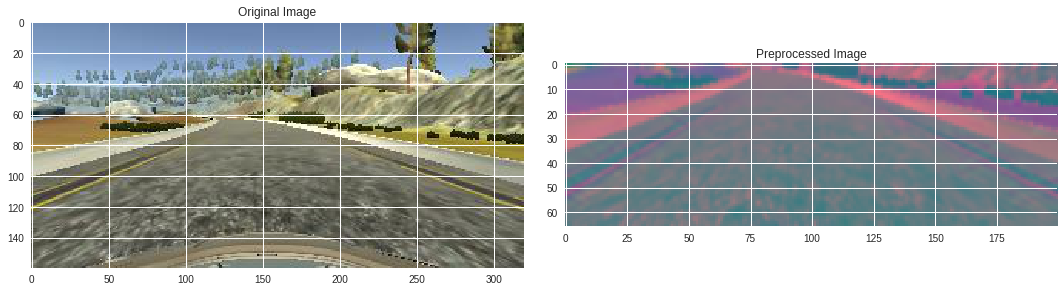

In [34]:
image_path = image_paths[60]
original_image = mpimg.imread(image_path)
preprocessed_image = img_preprocess(image_path)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')


In [0]:
#Make an iterator that computes the function 
#using arguments from each of the iterables. 
X_train = np.array(list(map(img_preprocess, X_train))) #Each image in X_traing goes as parameter
X_valid = np.array(list(map(img_preprocess, X_valid))) #Each image in X_traing goes as parameter


(914, 66, 200, 3)


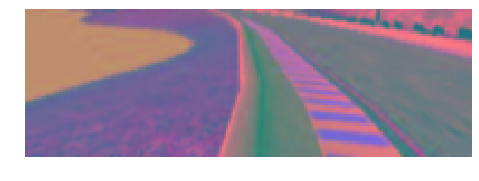

In [36]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

  92

**A "dead" ReLU** always outputs the same value (zero as it happens, but that is not important) for any input. Probably this is arrived at by learning a large negative bias term for its weights.

In turn, that means that it takes no role in discriminating between inputs. For classification, you could visualise this as a decision plane outside of all possible input data.

Once a ReLU ends up in this state, it is unlikely to recover, because the function gradient at 0 is also 0, so gradient descent learning will not alter the weights. "Leaky" ReLUs with a small positive gradient for negative inputs (y=0.01x when x < 0 say) are one attempt to address this issue and give a chance to recover.

The **sigmoid and tanh** neurons can suffer from similar problems as their values saturate, but there is always at least a small gradient allowing them to recover in the long term.

In [0]:
def nvidia_model():
  model = Sequential()
  #subsample => tuple of length 2. Factor by which to subsample output. Also called strides elsewhere.
  
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu')) #division decreased significantly so we will not use subsample
  model.add(Convolution2D(64, 3, 3, activation='elu')) #division decreased significantly so we will not use subsample
  model.add(Dropout(rate=0.5)) #reduce overfitting
  
  model.add(Flatten())
  model.add(Dense(units=100, activation='elu')) #fully connected layer, 100 nodes
  model.add(Dropout(rate=0.5)) #reduce overfitting
  
  model.add(Dense(units=50,  activation='elu')) #fully connected layer ,  50 nodes
  model.add(Dropout(rate=0.5)) #reduce overfitting

  model.add(Dense(units=10,  activation='elu')) #fully connected layer ,  10 nodes
  model.add(Dropout(rate=0.5)) #reduce overfitting

  model.add(Dense(1))
  
  adam = Adam(lr=1e-3) #0.001
  model.compile(loss='mse', optimizer=adam)
  
  return model

In [38]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
__________

In [39]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid,y_valid),
          batch_size=100, verbose=1, shuffle=1)

Train on 914 samples, validate on 229 samples
Epoch 1/30
914/914 [==============================] - 2s 2ms/step - loss: 0.8718 - val_loss: 0.1167
Epoch 2/30
914/914 [==============================] - 1s 802us/step - loss: 0.2938 - val_loss: 0.1246
Epoch 3/30
914/914 [==============================] - 1s 783us/step - loss: 0.1936 - val_loss: 0.1077
Epoch 4/30
914/914 [==============================] - 1s 768us/step - loss: 0.1650 - val_loss: 0.1062
Epoch 5/30
914/914 [==============================] - 1s 727us/step - loss: 0.1389 - val_loss: 0.1043
Epoch 6/30
914/914 [==============================] - 1s 735us/step - loss: 0.1402 - val_loss: 0.1040
Epoch 7/30
914/914 [==============================] - 1s 746us/step - loss: 0.1306 - val_loss: 0.0992
Epoch 8/30
914/914 [==============================] - 1s 731us/step - loss: 0.1325 - val_loss: 0.0988
Epoch 9/30
914/914 [==============================] - 1s 729us/step - loss: 0.1318 - val_loss: 0.0983
Epoch 10/30
914/914 [=================

Text(0.5, 0, 'Epoch')

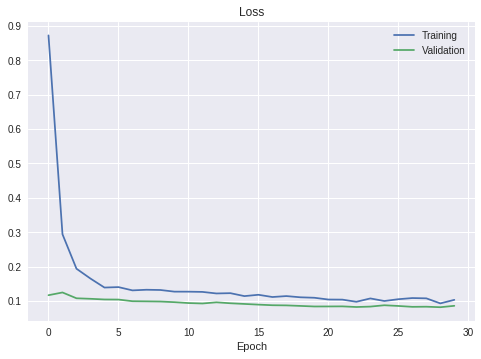

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
#model.save('model.h5')
#from google.colab import files
#files.download('model.h5')